In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

#Example 1: 

# Description 
We have four states $$x = [x_{1}, x_{2}, \dot{x_{1}}, \dot{x_{2}}]^{T}$$
$$ y = [x_{1}, x_{2}]^{T}$$
The state space model is described as: $$\dot{x}(t) = Ax(t)$$
$$y(t) = Cx(t)$$
where: 
$$A = \begin{bmatrix} 0&0&1&0\\0&0&0&1\\0&0&0&0\\0&0&0&0 \end{bmatrix}$$, $$C = \begin{bmatrix} 1&0&0&0\\0&1&0&0 \end{bmatrix}$$

## State Extrapolation Equation: 
$$\hat{x_{n+1,n}} = F\hat{x_{n,n}}$$ 
where $$F = \begin{bmatrix} 1&0&\Delta t&0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1 \end{bmatrix}$$

## Covariance Extrapolation Equation 
$$P_{n+1,n} = FP_{n,n}F^{T} + Q_{n}$$
where $$Q_{n} = \begin{bmatrix} \sigma_{x_{1}}^{2}&0&0&0\\0&\sigma_{x_{2}}^{2}&0&0\\0&0&\sigma_{\dot{x_{1}}}^{2}&0\\0&0&0&\sigma_{\dot{x_{1}}}^{2} \end{bmatrix}$$

## Kalman Gain Update Function 
Since the observed/measured variables are: 
$$z_{m} = [x_{1}, x_{2}]^{T}$$
and $$z_{m} = Hx$$
$$K_{n} = P_{n,n-1}H^{T}(HP_{n,n-1}H_{T} + R_{n})$$
where $$H = \begin{bmatrix} 1&0&0&0\\0&1&0&0 \end{bmatrix}$$
and
$$R = \begin{bmatrix} \sigma_{x_{1}}^{2}&0\\0&\sigma_{x_{2}}^{2} \end{bmatrix}$$ 

## Update State Equation 
$$\hat{x_{n,n}} = \hat{x_{n,n-1}} + K_{n}(z_{n} - H\hat{x_{n,n-1}})$$

## Update Estimate Uncertainty Equation 
$$P_{n,n} = (I-K_{n}H)P_{n,n-1}(I-K_{n}H)^{T} + K_{n}R_{n}K_{n}^{T}$$ 

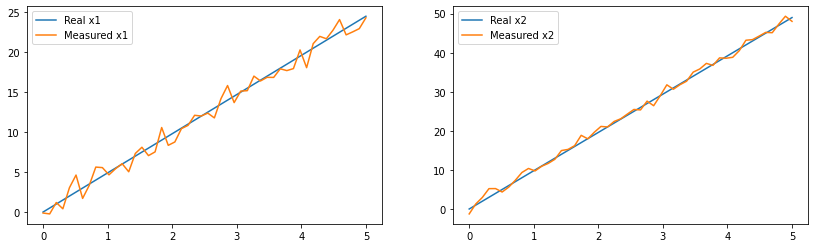

In [3]:
#Process noise
sigma_x1 = 1
sigma_x2 = 1
sigma_v1 = 1 
sigma_v2 = 1

#Measurement Noise
sigma_mx1 = 1
sigma_mx2 = 1

#Generate the data: assume constant velocity
N_steps = 50 
dt = 0.1 #s
t = np.linspace(0, N_steps*dt, N_steps)

v1_true = np.ones(N_steps)*5 #m/s
v2_true = np.ones(N_steps)*10 #m/s

x1_0 = 0 #m
x2_0 = 0 #m

x1_true = [x1_0 + v*dt*i for i, v in enumerate(v1_true)]
x2_true = [x2_0 + v*dt*i for i, v in enumerate(v2_true)] 

x1_meas = [x+np.random.normal(0, sigma_x1) for x in x1_true]
x2_meas = [x+np.random.normal(0, sigma_x2) for x in x2_true]
x1m_sigma = np.ones_like(x1_meas)*sigma_mx1 #Std for measurement x1
x2m_sigma = np.ones_like(x2_meas)*sigma_mx2 #Std for measurement x2

fig, ax = plt.subplots(1, 2)
ax[0].plot(t, x1_true, label='Real x1')
ax[0].plot(t, x1_meas, label='Measured x1')
ax[0].legend() 

ax[1].plot(t, x2_true, label='Real x2')
ax[1].plot(t, x2_meas, label='Measured x2')
ax[1].legend() 

fig.set_figwidth(14)

plt.show()

In [4]:
F = np.matrix([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]]) #State transition matrix 
Q = np.matrix([[sigma_x1**2,0,0,0], [0,sigma_x2**2,0,0],[0,0,sigma_v1**2,0],[0,0,0,sigma_v2**2]])#Process noise uncertainty
H = np.matrix([[1,0,0,0],[0,1,0,0]]) #Observation Matrix
R = np.matrix([[sigma_mx1**2,0],[0,sigma_mx2**2]]) #Measurement Uncertainty
Kn = lambda P: P*H.T*(H*P*H.T+R)**-1 #Kalman Gain

In [5]:
#Process: Initialize -> <Measure - Update - Predict> - loop

#Initialize: 
x1_0_guess = 10 #initial guessing values
x2_0_guess = 10 #initial guessing values
v1_0_guess = 10 
v2_0_guess = 10

sigma_x1_init = 100
sigma_x2_init = 100
sigma_v1_init = 100
sigma_v2_init = 100

#Q_init = np.matrix([[sigma_x1_init**2,0,0,0], [0,sigma_x2_init**2,0,0],[0,0,sigma_v1_init**2,0],[0,0,0,sigma_v2_init**2]])

x_est = np.array([[x1_0_guess, x2_0_guess, v1_0_guess, v2_0_guess]])
x_pred = x_est
P_now = np.array([[sigma_x1_init**2,0,0,0],[0,sigma_x2_init**2,0,0],[0,0,sigma_v1_init**2,0],[0,0,0,sigma_v2_init**2]])

i = 0
for x1, x2, sx1, sx2 in zip(x1_meas, x2_meas, x1m_sigma, x2m_sigma): 
    #Predict state and uncertainty
    x1_0, x2_0, v1_0, v2_0 = x_est[i]
    x_0 = np.array([[x1_0],[x2_0],[v1_0],[v2_0]])
    
    x_next = np.array(F*x_0)
    x_pred = np.append(x_pred, [x_next.flatten()], axis=0)
    
    P_next = F*P_now*F.T + Q #Extrapolate the uncertainty
    
    #Measurement update:
    z_m = np.array([[x1], [x2]])
    K_n_next = Kn(P_next) 
    x_est_m = np.array(x_next + K_n_next*(z_m - H*x_next)).flatten()
    x_est = np.append(x_est, [x_est_m], axis=0)
    
    Id = np.identity(len(x_next)) #identity matrix in size of state x 
    P_now = (Id - K_n_next*H)*P_next*(Id-K_n_next*H).T + K_n_next*R*K_n_next.T
    
    i += 1

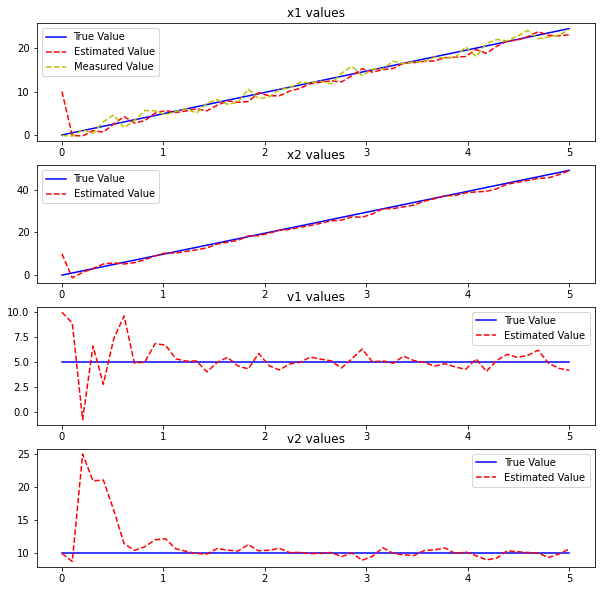

In [6]:
x1_est = x_est[:, 0][:-1]
x2_est = x_est[:, 1][:-1]
v1_est = x_est[:, 2][:-1]
v2_est = x_est[:, 3][:-1]

fig, ax = plt.subplots(4, 1)

ax[0].set_title("x1 values")
ax[0].plot(t, x1_true, 'b', label='True Value')
ax[0].plot(t, x1_est, 'r--', label="Estimated Value")
ax[0].plot(t, x1_meas, 'y--', label="Measured Value")
ax[0].legend()

ax[1].set_title("x2 values")
ax[1].plot(t, x2_true, 'b', label='True Value')
ax[1].plot(t, x2_est, 'r--', label="Estimated Value")
ax[1].legend()

ax[2].set_title("v1 values")
ax[2].plot(t, v1_true, 'b', label='True Value')
ax[2].plot(t, v1_est, 'r--', label="Estimated Value")
ax[2].legend()

ax[3].set_title("v2 values")
ax[3].plot(t, v2_true, 'b', label='True Value')
ax[3].plot(t, v2_est, 'r--', label="Estimated Value")
ax[3].legend()

fig.set_figwidth(10)
fig.set_figheight(10)

plt.show()


In [7]:
x_est = np.array([[x1_0_guess, x2_0_guess, v1_0_guess, v2_0_guess]])
x_pred = x_est
P_now = np.array([[sigma_x1_init**2,0,0,0],[0,sigma_x2_init**2,0,0],[0,0,sigma_v1_init**2,0],[0,0,0,sigma_v2_init**2]])

x_pred_tot = []

i = 0
for x1, x2, sx1, sx2 in zip(x1_meas, x2_meas, x1m_sigma, x2m_sigma):     
    
    #Predict state and uncertainty
    x1_0, x2_0, v1_0, v2_0 = x_est[i]
    x_0 = np.array([[x1_0],[x2_0],[v1_0],[v2_0]])
    
    x_next = np.array(F*x_0).reshape(-1, 1)
    x_pred = np.append(x_pred, x_next.reshape(1, -1), axis=0)
    
    P_next = F*P_now*F.T + Q #Extrapolate the uncertainty
    
    #Measurement update:
    z_m = np.array([[x1], [x2]])
    K_n_next = Kn(P_next) 
    x_est_m = np.array(x_next + K_n_next*(z_m - H*x_next)).reshape(1, -1)
    x_est = np.append(x_est, x_est_m, axis=0)
    
    Id = np.identity(len(x_next)) #identity matrix in size of state x 
    P_now = (Id - K_n_next*H)*P_next*(Id-K_n_next*H).T + K_n_next*R*K_n_next.T
    
    #Calculate future values for x, based on the estimate alone
    x_pred_vals = x_est
    for j in range(len(t)-len(x_est)): 
        x_next = np.array(F*x_pred_vals[-1].reshape(-1, 1))
        x_pred_vals = np.append(x_pred_vals, x_next.reshape(1, -1), axis=0)
    x_pred_tot.append(x_pred_vals)
    i += 1


<IPython.core.display.Javascript object>


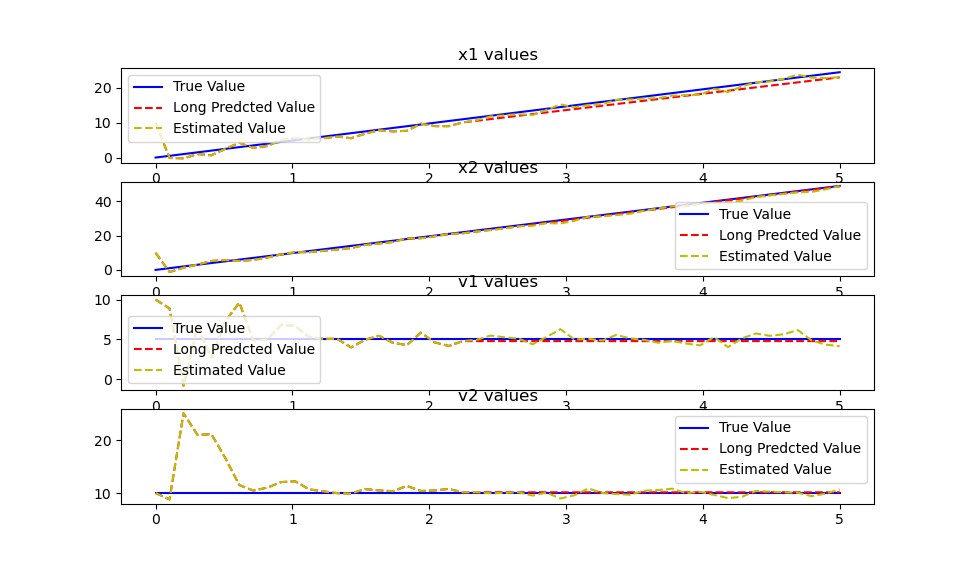

IntSlider(value=0, continuous_update=False, max=48)

In [8]:
%matplotlib notebook
from ipywidgets import *

i = len(x_pred_tot)-2

fig, ax = plt.subplots(4, 1)

x1_pr = x_pred_tot[i][:,0]
x2_pr = x_pred_tot[i][:,1]
v1_pr = x_pred_tot[i][:,2]
v2_pr = x_pred_tot[i][:,3]

ax[0].set_title("x1 values")
ax[0].plot(t, x1_true, 'b', label='True Value')
l1, = ax[0].plot(t, x1_pr, 'r--', label="Long Predcted Value")
ax[0].plot(t, x1_est, 'y--', label="Estimated Value")
ax[0].legend()

ax[1].set_title("x2 values")
ax[1].plot(t, x2_true, 'b', label='True Value')
l2, = ax[1].plot(t, x2_pr, 'r--', label="Long Predcted Value")
ax[1].plot(t, x2_est, 'y--', label="Estimated Value")
ax[1].legend()

ax[2].set_title("v1 values")
ax[2].plot(t, v1_true, 'b', label='True Value')
l3, = ax[2].plot(t, v1_pr, 'r--', label="Long Predcted Value")
ax[2].plot(t, v1_est, 'y--', label="Estimated Value")
ax[2].legend()

ax[3].set_title("v2 values")
ax[3].plot(t, v2_true, 'b', label='True Value')
l4, = ax[3].plot(t, v2_pr, 'r--', label="Long Predcted Value")
ax[3].plot(t, v2_est, 'y--', label="Estimated Value")
ax[3].legend()

fig.set_figwidth(10)
fig.set_figheight(10)

def update(change=i): 
    l1.set_ydata(x_pred_tot[int(change.new)][:,0])
    l2.set_ydata(x_pred_tot[int(change.new)][:,1])
    l3.set_ydata(x_pred_tot[int(change.new)][:,2])
    l4.set_ydata(x_pred_tot[int(change.new)][:,3])

sl = IntSlider(min=0, max=48, step=1, value=0, continuous_update=False)
sl.observe(update, 'value')
sl
